### Predicción de ETo usando la librería **eto**

In [251]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from eto import ETo

import warnings
warnings.filterwarnings('ignore')

Preparación de los datos

In [252]:
tsdata = pd.read_csv('example_daily.csv', parse_dates=True, index_col='date')
et1 = ETo()

z_msl = 500 # Altitud de la estación de medición sobre el nivel del mar (metros)
lat = -43.6 # Latitud de la estación de medición (grados)
lon = 172 # Longitud de la estación de medición (grados)
TZ_lon = 173 # Longitud del centro de la timezone (grados) - Solo para ETo horaria
freq = 'D' # Frecuencia para la medición (min horas (H) y max meses (M))

# Si hay valores suficientes devuelve un dataframe estimando el resto de valores necesarios
# Si son insuficientes devuelve un error
et1.param_est(tsdata, freq, z_msl, lat, lon, TZ_lon)
et1.ts_param.head()


,R_s,T_max,T_min,e_a,R_n,G,T_mean,T_dew,RH_min,RH_max,...,n_sun,U_z,P,gamma,e_max,e_min,e_s,delta,R_a,U_2
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,13.4,17.700001,13.7,1.60,9.285734,0.0,15.70,NaN,NaN,NaN,...,NaN,NaN,95.527647,0.063526,2.025376,1.567747,1.796562,0.114199,44.443793,2.0
2000-01-02,14.7,19.600000,13.0,1.68,10.017707,0.0,16.30,NaN,NaN,NaN,...,NaN,NaN,95.527647,0.063526,2.281006,1.497771,1.889388,0.118099,44.386929,2.0
2000-01-03,12.2,21.700001,9.2,1.09,8.475450,0.0,15.45,NaN,NaN,NaN,...,NaN,NaN,95.527647,0.063526,2.595970,1.163665,1.879817,0.112606,44.325018,2.0
2000-01-04,4.2,14.400000,8.4,1.04,4.385135,0.0,11.40,NaN,NaN,NaN,...,NaN,NaN,95.527647,0.063526,1.640576,1.102347,1.371462,0.089314,44.258075,2.0
2000-01-05,14.1,11.700000,8.9,1.12,9.540114,0.0,10.30,NaN,NaN,NaN,...,NaN,NaN,95.527647,0.063526,1.375058,1.140328,1.257693,0.083748,44.186116,2.0


In [253]:
# Devuelve una Serie
eto1 = et1.eto_fao()

# Convertir la Serie en un Dataframe
def serie_to_dataframe(serie, col1_name, col2_name):
    serie = serie.reset_index()
    serie.columns = [col1_name, col2_name]
    return serie

eto1 = serie_to_dataframe(eto1, 'Date', 'ETo')
eto1.head(10)

,Date,ETo
0,2000-01-01,2.31
1,2000-01-02,2.52
2,2000-01-03,3.20
3,2000-01-04,1.49
4,2000-01-05,2.00
5,2000-01-06,3.64
6,2000-01-07,2.61
7,2000-01-08,1.80
8,2000-01-09,3.68
9,2000-01-10,2.45


In [254]:
df = pd.merge(tsdata, eto1, left_index=True, right_on='Date')
df.set_index("Date", inplace=True)
df.index = pd.to_datetime(df.index)
df

,R_s,T_max,T_min,e_a,ETo
Date,,,,,
2000-01-01,13.4,17.700001,13.7,1.60,2.31
2000-01-02,14.7,19.600000,13.0,1.68,2.52
2000-01-03,12.2,21.700001,9.2,1.09,3.20
2000-01-04,4.2,14.400000,8.4,1.04,1.49
2000-01-05,14.1,11.700000,8.9,1.12,2.00
...,...,...,...,...,...
2015-12-27,NaN,19.200001,9.6,1.39,3.43
2015-12-28,NaN,18.100000,13.4,1.42,2.88
2015-12-29,NaN,18.600000,7.2,1.15,3.71


In [255]:
# Procesar valores Nan
df.fillna(method='ffill', inplace=True)
df.isna().sum()

R_s      0
T_max    0
T_min    0
e_a      0
ETo      0
dtype: int64

División de los datos para series temporales

In [256]:
def create_sequences(df, features, target, lookback):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df[features].iloc[i:i+lookback].values) # Coleccionar los features dejando fuera los más recientes (lookback)
        y.append(df[target].iloc[i+lookback]) # Coleccionar para cada paso temporal el target de 'lookback' días posteriores
    return np.array(X), np.array(y) # Devolver X como 3D array (samples, time_steps, features) e y como 1D array

In [257]:
train_size = int(len(df) * 0.75)
train, test = df[:train_size], df[train_size:]

features = ['R_s', 'T_max', 'T_min', 'e_a']
target = 'ETo'

# Estandarizar datos antes de la división (solo los features)
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

X_train, y_train = create_sequences(train, features, target, lookback=5) # X --> (4360, 5, 4); y --> (4360,)
X_test, y_test = create_sequences(test, features, target, lookback=5) # X --> (1451, 5, 4); y --> (1451,)

Construcción del modelo: RNN

In [258]:
model = Sequential()

# Recibe de input_shape los time_steps y el número de features
# Cuando se apilan varias LSTM debe establecerse que devuelva secuencias, de lo contrario solo devuelve el último output
model.add(LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1)) # Predicte el siguiente paso temporal

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 5, 256)         │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,169 (2.41 MB)

 Trainable params: 631,169 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo

In [259]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [260]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.6614 - mae: 1.2113 - val_loss: 1.5090 - val_mae: 0.8996
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9559 - mae: 0.7211 - val_loss: 1.5668 - val_mae: 0.9190
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8378 - mae: 0.6741 - val_loss: 1.2017 - val_mae: 0.8107
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7067 - mae: 0.6186 - val_loss: 1.2962 - val_mae: 0.8332
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6496 - mae: 0.6014 - val_loss: 1.3121 - val_mae: 0.8434
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6691 - mae: 0.5983 - val_loss: 1.2897 - val_mae: 0.8270
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6174 - mae: 0.5742 - val_loss: 1.2795 - val_mae: 0.8161
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6134 - mae: 0.5782 - val_loss: 1.2395 - val_mae: 0.8122
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

In [261]:
valid_error = model.evaluate(X_test, y_test)

print(f'Mean Squared Error: {valid_error[0]:.2f}')
print(f'Mean Absolute Error: {valid_error[1]:.2f}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0141 - mae: 0.7472
Mean Squared Error: 1.20
Mean Absolute Error: 0.81


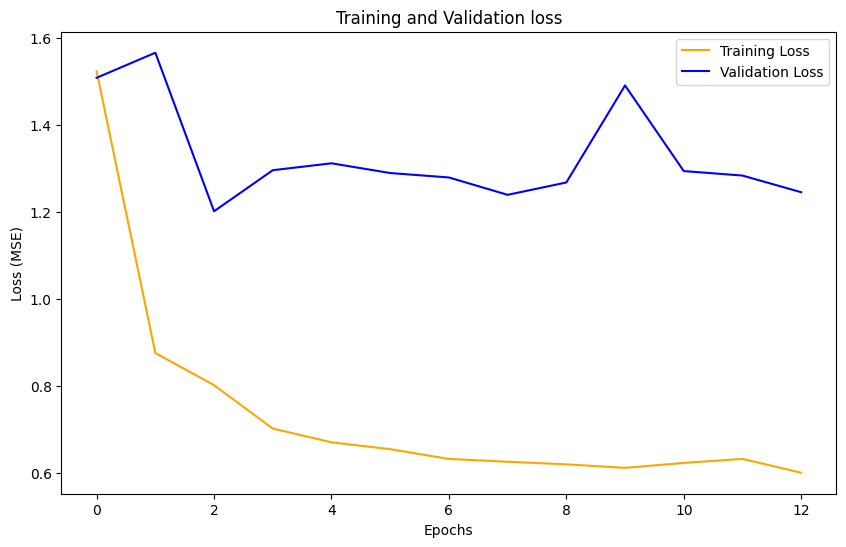

In [262]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
plt.show()

In [263]:
y_pred = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


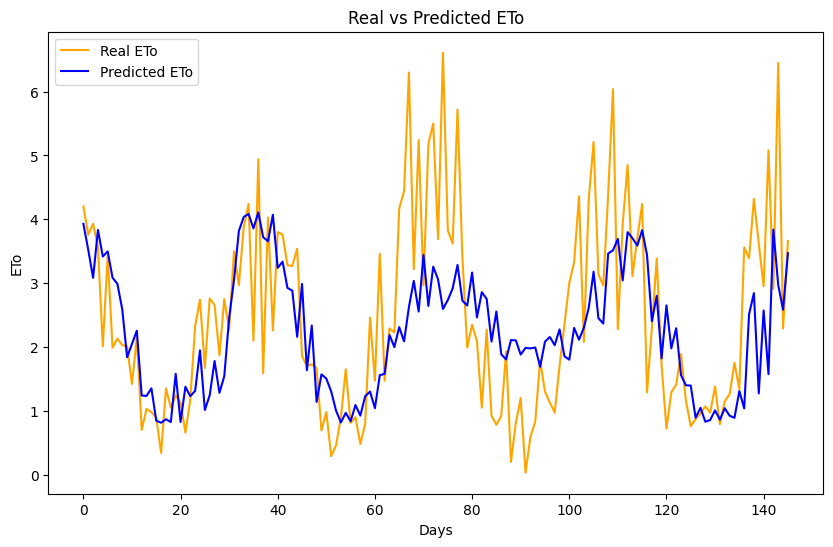

In [264]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[::10], label='Real ETo', color='orange')
plt.plot(y_pred[::10], label='Predicted ETo', color='blue')

plt.title('Real vs Predicted ETo')
plt.xlabel('Days')
plt.ylabel('ETo')
plt.legend()
plt.show()